# B8 Software Suite: Analysis of XSPEDS data using Single Photon Counting and Bragg Spectroscopy

### Author: Yufei Pei
College: Lady Margaret Hall

Supervisor: Prof Sam Vinko

## Overview: 
This software is used to analyse data collected in X-ray Single-Photon Energy-Dispersive Spectroscopy (XSPEDS) experiments. 

In these experiments, hot, dense plasma sources are created, and the photons emitted from them collected using CCD cameras to study the behaviour of such systems. We are in particular interested in extracting the spectrum of emission intensity vs. photon energy, which requires the identification of the energy of each photon as well as accurate counting of photons in each energy bins. The latter is done by the single-photon counting(SPC) algorithm, which takes the images as imput and returns the positions of the photons identified;the former is achieved by making use of Bragg's law,

$$
    n \frac{hc}{E}=2d \sin\theta
$$

which associates the photon energy $E$ with the deflection angle $\theta$. Thus, by deflecting the emitted photons using crystals with known lattice spacing $2d$, we are able to set up a one-to-one correspondence between the position of the photon on the CCD camera and its energy, using the geometry of the experiment which can be extracted from the information on the CCD images. 

The major difficulties in the previous approach are presented by the presence of background noise and multi-photon events(MPE). The fluctuation of background noise may result in the identification of spurious events, whereas the presence of MPE, entangled clusters due to more than one photon, making it hard to determine the actual positions of each photon. 

This notebook is organized in the following way: in the first part, after importing the data, we present the SPC algorithm, making use of the gradient descent method; we also present an algorithm to eliminate the spurious events due to the fluctuation of noise, by maintaining that the number of electron-hole pairs created by photons, and thus the total brightness it created, must obeys Gaussian distribution, and thus the spurious events can be identified and eliminated. In the second part, using the result of the SPC section, We present methods to identify the spectral lines, and use the energy values of them known to us to determine the geometry, and in the end plot the spectrum.

## Module importation

At the beginning, the program imports the module required.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import itertools
import numpy as np
from PIL import Image
from scipy.stats import logistic
from scipy.stats import chi2
from scipy.stats import poisson
from scipy.stats import mode
import math
from copy import deepcopy
from statistics import mean
import time
import csv
from IPython import display

## Importing the data

Imports the data in hdf5 format, and generate some basic information of the data.


<b><u>Enter the path of the data file here:</u></b>

In [9]:
hdf5_file_address = "sxro6416-r0504.h5"

<i>NB: This part of the code is provided by the supervisor at the beginning of the project.</i>

In [10]:
def import_images(f_name):
    
    # Name of the hdf file that contain the data we need
    # Open the hdf5 file, use the path to the images to extrate the data and place
    # it in the image data object for further manipulation and inspection.
    datafile = h5py.File(f_name, 'r')
    image_data = []
    for i in itertools.count(start=0):
        d = datafile.get(f'Configure:0000/Run:0000/CalibCycle:{i:04d}/Princeton::FrameV2/SxrEndstation.0:Princeton.0/data')
        if d is not None:
            # actual image is at first index
            image_data.append(d[0])
        else:
            break

    # Tell me how many images were contained in the datafile
    print(f"Loaded {len(image_data)} images")

    return image_data

In [11]:
image_data = import_images(hdf5_file_address)

Loaded 20 images


We have imported an array of images, each of them having dimensions $2048\times2048$ and entries between 0 and a few hundreds, representing the intensity value, or ADU value, of each pixel of the CCD camera. To have a look of the images, we plot one of them:

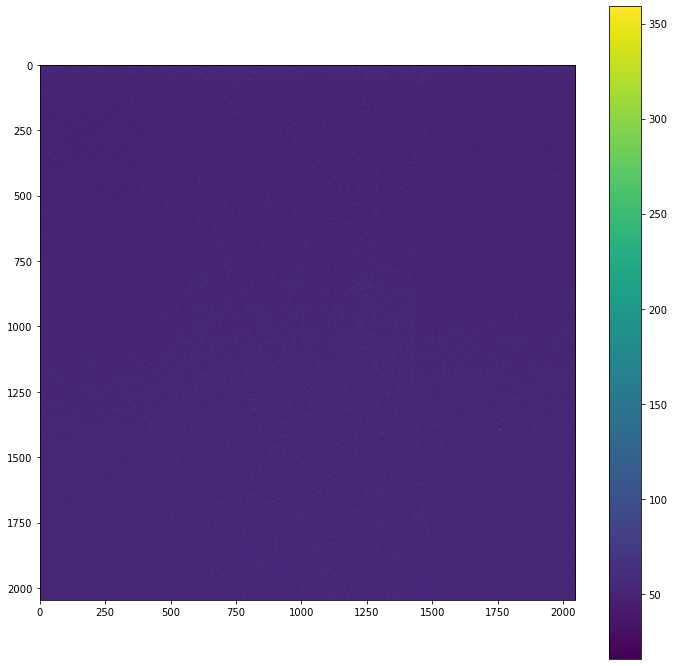

In [12]:
# Change the size of the plot used in this notebook
plt.rcParams["figure.figsize"]=[12, 12];
plt.imshow(image_data[1])
plt.colorbar()

Plot the histogram of the ADU value of each pixels in one of the images in `image_data`:

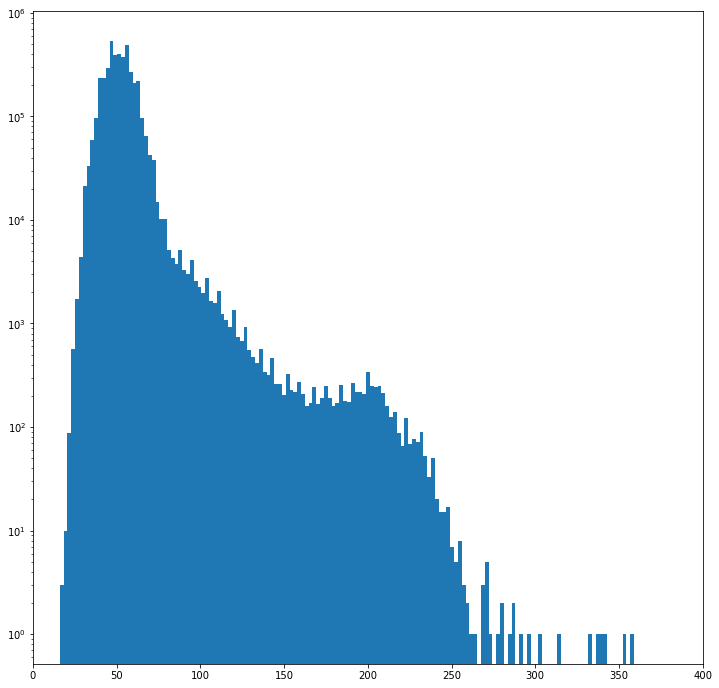

In [13]:
plt.hist(image_data[1].flatten(), bins = 150);
plt.yscale('log')
plt.xlim([0,400]);

From the above histagram, we are able to see the large pedestal, a normal-distributed peak on the left around $\mathrm{ADU}=50$ representing the background noise, and the signals on the right corresponding to photon events. We also identify some spurious bright spots in the image with too large ADU values; these will be filtered in the algorithm.

## Single Photon Counting

The SPC algorithm is build on the assumption that each photon event is associated with a 2-dimensional Gaussian distribution
$$
    I(x,y)=\frac{A}{\sigma_x \sigma_y }\exp\left(-\frac{(x-x_0)^2}{2\sigma_x^2}-\frac{(y-y_0)^2}{2\sigma_y^2}\right)
$$
and that the increment in the ADU value of each pixel is given by the integration of such a distribution within:
$$
\begin{aligned}
    \mathrm{ADU_G}(i,j)&=\int_i^{i+1}\int_j^{j+1}I(x,y)\mathrm{d}y\mathrm{d}x
    \\
    &=\frac{\pi}{2}A\left[\mathrm{erf}\left(\frac{i+1-x0}{\sqrt{2}\sigma_x}\right)-\mathrm{erf}\left(\frac{i-x0}{\sqrt{2}\sigma_x}\right)\right]\left[\mathrm{erf}\left(\frac{j+1-y0}{\sqrt{2}\sigma_y}\right)-\mathrm{erf}\left(\frac{j-y0}{\sqrt{2}\sigma_y}\right)\right]
\end{aligned}
$$

Therefore, our algorithm should find the peaks of ADU values in the image, identify a Gaussian distrubition that best resembles the entries around it and return the parameters $x_0,y_0,\sigma_x,\sigma_y,A$. This is achieved by the SPC algorithm, which takes each image in `image_data` as input and returns the position and the intensity of the photon.

### Step 0: Creating a demo data

A demo data is cropped out from an image given to demonstrate how the SPC algorithm works.

It is selected from the portion `[492:525, 1308:1340]` of the second image provided.

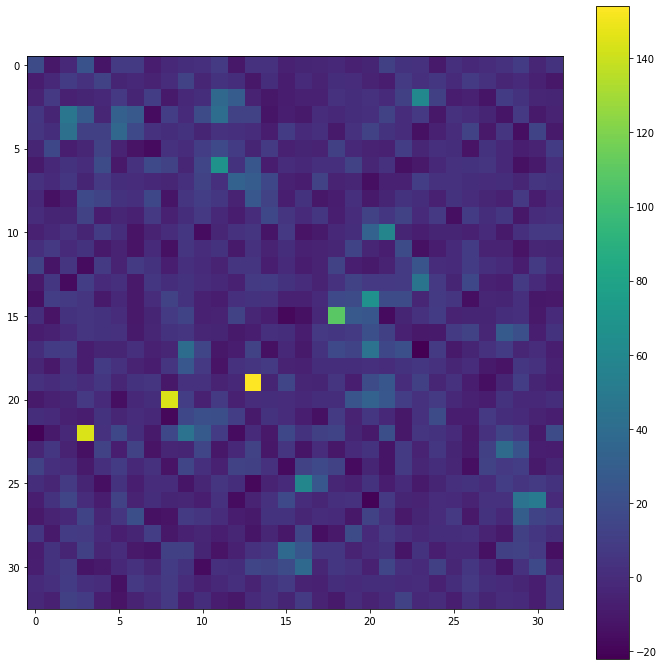

In [14]:
demo_data = image_data[1][492:525, 1308:1340].astype(int) - 50

# Plot the demo data
plt.imshow(demo_data)
plt.colorbar()

### Step 1: Image normalisation

<u>Goal of this step:</u> Normalise the images, so as to set the mean of the pedestals and thus the noise contribution to be 0.

Since it is found that in some images, the bottom is brighter than the top, image normalisation is done by cutting the image horizontally into `norm_cut_num` strips, with each strip having a height of `2048/norm_cut_num`, and subtracting each entry in the strip with the mode of the strip. This guarantees that the mode of the Gaussian background noise is set to 0 throughout the image. From the properties of Gaussian distributions, this also guarantees that the mean goes to 0. <i>NB: The demo data have been normalised in such a way.</i>

In [15]:
#Set the number of strips to cut
norm_cut_num = 128

In [16]:
def image_normalisation(im, cut_num):
    
    # Input: the image; the number of strips to cut
    # Output: the normalised image
    
    # Make a copy of the input data, using the deepcopy function to ensure that im remains unchanged:
    dat = deepcopy(im.astype(int))
    # NB: astype(int) is added to convert the entries of im from unsigned int (0-65536) to signed int.
    
    # Make sure that cut_num is a factor of the size of the image, i.e. 2048. If not, raise an error.
    try:
        cut_height = int(2048/cut_num)
        if(cut_height * cut_num != 2048):
            raise ValueError('Invalid norm_cut_num')
    except ValueError as e:
        print('Error: ', e)
    
    # Normalise the image
    for i in range(32):
        # Find the mode of the strip; if multiple modes are found, select the minimum of them
        im_mode = min(mode(dat[i*64:(i+1)*64,:].flatten())[0])
        
        dat[i*64:(i+1)*64,:] = dat[i*64:(i+1)*64,:].astype(int) - im_mode
    
    return dat


# Applying this function to our image_data
for i in range(len(image_data)):
    image_data[i] = image_normalisation(image_data[i], norm_cut_num)


Checking the norm of the pedestal has been set to 0 by plotting the histogram:

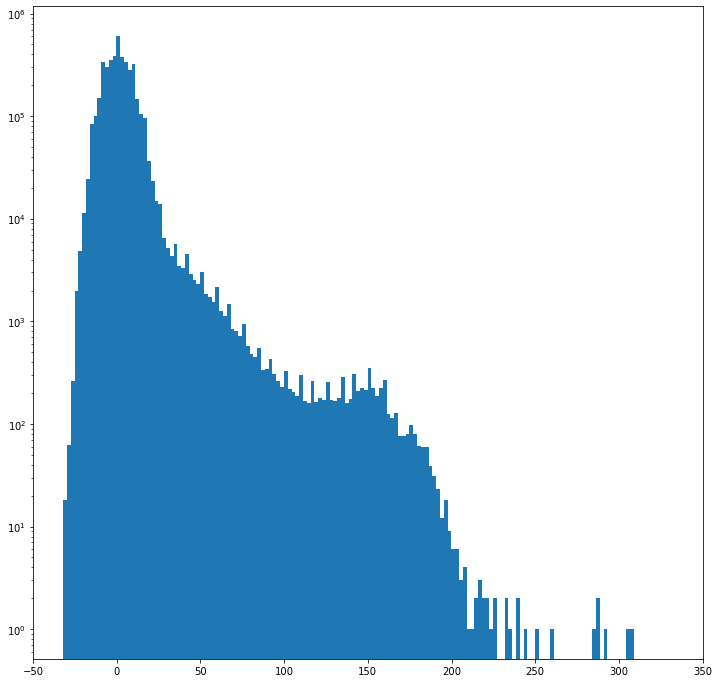

In [17]:
plt.hist(image_data[1].flatten(), bins = 150);
plt.yscale('log')
plt.xlim([-50,350]);

The algorithm then sets the pixels near the boundaries to be 0, as it is noticed that pixels near the boundaries may have different ADU values, potentially due to instrumental error.

In [18]:
def boundary_setting(im):
    
    # Input: a normalised image
    # Output: the image, with the entries near the edges set to 0
    
    # Find the height and width of im
    h = im.shape[0]
    w = im.shape[1]
    
    dat = deepcopy(im.astype(int))
    
    # Set the entries near the boundary to 0
    for i in range(h):
        for j in range(w):
            if((i < 2 or i > h - 2) or (j < 4 or j > w - 2)):
                dat[i, j]=0
                
    return dat

# Applying this function to our normalised image_data
for i in range(len(image_data)):
    image_data[i] = boundary_setting(image_data[i])

### Step 2: Thresholding & box assignment

<u>Goal of this step:</u> Split each image into small portions that can be considered separately.

We assume that each photon event can only have have influence in the surrounding pixels; pixels having a distance greater than 2px cannot be influenced. Hence, if one photon or a set of photons is separated by a distance of at least 2px from all other photons, we can single it/them out to be analysed separately.

Using this, the algorithm in this step (1) Applies a threshold to the images, to find the pixels with large ADUs; (2) Assign rectangular 'boxes' to enclose the large-ADU pixels and its surroundings, making sure that (i) events in different boxes are separated and do not have influence on each other and (ii) if there are more than one events in one box, then these events are entangled. The contents within these boxes are going to be considered separately when, in the next step, exact positions of the photon events are to be found.

#### 2.1 Thresholding

We select the threshold value to be 30; this allows most photon events and at the same time a small portion of noises. The noise-cancelling algorithm is presented in step 4.

In [19]:
# Set the threshold:
thres = 30

In [20]:
# The thresholding algorithm.

def thresholding(data, threshold):
    
    # Input: a normalised image
    # Output: A matrix, having the same dimensions of the input image, with each entry being 0 if the corresponding entry in the input 
    #         matrix is < threshold, and 1 if it's >= threshold
    
    def compare(val):
        if(val >= threshold):
            return 1
        else:
            return 0
    
    label_matrix = [[compare(data[i, j]) for j in range(data.shape[1])] for i in range(data.shape[0])]
    
    return label_matrix

Applying it on our cute little demo data: 

Yellow pixels are entries greater than threshold and purple pixels are other entries.

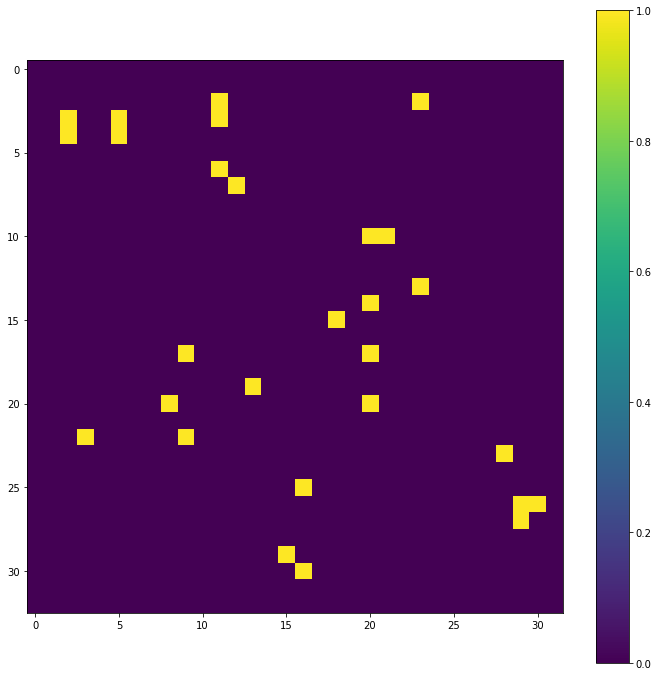

In [21]:
demo_label_matrix = thresholding(demo_data, thres)

plt.imshow(demo_label_matrix)
plt.colorbar()

#### 2.2 Box assignment

In [22]:
# Establish a class of box, containing the coordinate of the edges, as well as the width and height of it.

class box:
    'used to enclose photon events'
    
    def __init__(self, xmin, ymin, xmax, ymax):
        self.x_min = xmin
        self.y_min = ymin
        self.x_max = xmax
        self.y_max = ymax
        
        self.width = xmax - xmin + 1
        self.height = ymax - ymin + 1
    
    def params(self):
        # Return the parameters of the box
        return [self.x_min, self.y_min, self.x_max, self.y_max]
    
    def hw(self):
        # Find the shape of the box
        return [self.height, self.width]

In [23]:
# The box assignment function

def boxing(thres_matrix, output = 'None'):
    
    # Input: the threshold matrix, coming from the thresholding() function
    # Output: A list of boxes identified within the image. 
    
    # The 'output' parameter determines whether the function prints some information for 
    # debugging or demonstration purposes.
    
    # Create a copy of the input matrix, so that it will not be changed
    m = np.array(deepcopy(thres_matrix))
    
    # Initialise the box list
    box_list = []
    
    #Prepare for plotting the dataset, if needed
    if(output != 'None'):
        fig, ax = plt.subplots(1)
                               
    # Search for entry 1's in the input matrix
    for i in range(m.shape[0]):
         for j in range(m.shape[1]):
            if(m[i, j] == 1):
                # An entry 1 is found: firstly, the box only contains this entry and its surrounding 3*3.
                x = i
                y = j
                
                x_min = x - 1
                y_min = y - 1
                x_max = x + 1
                y_max = y + 1
                
                # Search for if there is any more entry 1's in the surrounding 5*5:
                while(True):
                    # Flag identifying the presence of entry 1's
                    flag = 0
                    
                    # Set the current entry to 0, in order to avoid double counting
                    m[x, y] = 0
                    
                    for ii in range(x_min - 1, x_max + 2):
                        for jj in range(y_min - 1, y_max + 2):
                            # Check if the search has reached the boundary of the image; if so, skips.
                            if((ii >= m.shape[0]) or (jj >= m.shape[1])): 
                                continue
                            
                            elif(m[ii, jj] == 1): # More entry 1's are found
                                flag = 1
                                
                                # Set this entry to 0, in order to avoid double counting
                                m[ii, jj] = 0
                                
                                # Enlarge the box to accommodate all these entries found in this way,
                                # as they are assumed to be entangled and must be considered simultaneously
                                x_min = min(x_min, ii - 1)
                                y_min = min(y_min, jj - 1)
                                x_max = max(x_max, ii + 1)
                                y_max = max(y_max, jj + 1)
                                
                    # this searching process must be iterated until no more entry 1's are found 
                    # in the box's ambiance, and that it is safe to consider the elements whthin 
                    # this box separately.
                    if(flag == 0):
                        break
                
                #Append our box identified to the box list
                b = box(x_min, y_min, x_max, y_max)
                box_list.append(b)
                
                # Generate output, if needed
                if(output != 'None'):
                    print('box created containing [%d:%d, %d:%d]' % (x_min, x_max, y_min, y_max))
                    
                    # Add a rectangle representing this box to the plot
                    box_rect = patches.Rectangle((y_min - 0.5, x_min - 0.5), b.hw()[0], b.hw()[1],
                                                 linewidth = 1, edgecolor = 'r', facecolor = "none")
                    ax.add_patch(box_rect)

    # Generate output, if needed
    if(output != 'None'):
        print('plotting the left-top & right-bottom corner of the boxes:')
        plt.imshow(thres_matrix)
        plt.colorbar()
        plt.show()
    
    return box_list



Applying it on our beloved demo data:

box created containing [1:4, 10:12]
box created containing [1:3, 22:24]
box created containing [2:5, 1:3]
box created containing [2:5, 4:6]
box created containing [5:8, 10:13]
box created containing [9:11, 19:22]
box created containing [12:14, 22:24]
box created containing [13:18, 17:21]
box created containing [16:18, 8:10]
box created containing [18:20, 12:14]
box created containing [19:23, 7:10]
box created containing [19:21, 19:21]
box created containing [21:23, 2:4]
box created containing [22:24, 27:29]
box created containing [24:26, 15:17]
box created containing [25:28, 28:31]
box created containing [28:31, 14:17]
plotting the left-top & right-bottom corner of the boxes:


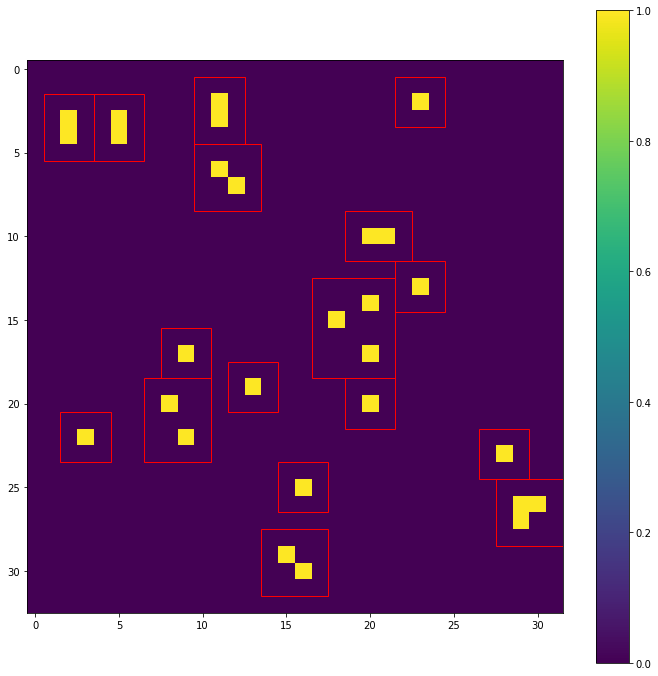

In [24]:
demo_box_list = boxing(demo_label_matrix, output = 'Yes please!')

### Step 3: Locating the exact photon position and intensity within each box using gradient descent method

<u>Goal of this step</u>: within each box, find the set of parameters $x_0,y_0,\sigma_x,\sigma_y,A$ for each photon that yields the least square error

$$
    \mathrm{error}=\sum_{i,j}(\mathrm{ADU}(i,j)-\mathrm{ADU_G}(i,j))^2
$$
where $\mathrm{ADU}(i,j)$ is the ADU value after normalisation.

This optimisation task is done by the gradient descent method. First, find the number of photons within each box, and an initial estimation of their parameters. Then, use the gradient descent method to optimise the parameters until convergence is reached.

#### 3.1 Preparation

We start by defining two constants, $\pi$ and $\sqrt{2}$, which will be frequently used in the calculation:

In [25]:
Pi = np.pi
Sqrt2 = np.sqrt(2)

We also define an array containing values of error functions($\mathrm{erf}$) of -10 to 10 that will be frequently evaluated in the calculations.

This array, `Erf`, satisfies: for an integer $x$ with $-10^6\le x\le 10^6$, 
$$
    \mathtt{Erf[x]} = \mathrm{erf}\left(\frac{x}{10^5}\right)
$$
where negative entries means counting backward as usual. Since the difference between $\mathrm{erf}(10)$ and 1(as well as $\mathrm{erf}(-10)$ and -1) is neglegible, we are able to use the value of $\mathrm{erf}(10)$ to replace error functions of values greater than 10.

In [26]:
Erf = []
for i in range(10**6 + 1):
    Erf.append(math.erf(i / 10**5))
for i in range(-10**6 , 0):
    Erf.append(math.erf(i / 10**5))

The algorithm first establishing a class of photon events(PE), containing the five parameters characterising it, namely $x_0,y_0,\sigma_x,\sigma_y,A$, as well as the width and height of the box in which it lives. It moreover contains the theoretical ADU value, $\mathrm{ADU}_\mathrm{G}$, caused by this photon alone. The actual theoretical ADU value is the linear superpositions of contributions from each photon.

Recall that $\mathrm{ADU}_\mathrm{G}$ is given by:
$$
\begin{aligned}
    \mathrm{ADU_G}(i,j)&=\int_i^{i+1}\int_j^{j+1}I(x,y)\mathrm{d}y\mathrm{d}x
    \\
    &=\frac{\pi}{2}A\left[\mathrm{erf}\left(\frac{i+1-x0}{\sqrt{2}\sigma_x}\right)-\mathrm{erf}\left(\frac{i-x0}{\sqrt{2}\sigma_x}\right)\right]\left[\mathrm{erf}\left(\frac{j+1-y0}{\sqrt{2}\sigma_y}\right)-\mathrm{erf}\left(\frac{j-y0}{\sqrt{2}\sigma_y}\right)\right]
\end{aligned}
$$

In [142]:
# Defining a function that calculates the part within the square bracket of the above expression:
def entry(i, x0, s):
    
    # Calculate the variable in the first and second pairs of parentheses, applying bounds of [-10, 10] to it from reasons
    # discussed above
    var_1 = max(-10, min(10, (-x0 + i + 1) / (Sqrt2 * s)))
    var_2 = max(-10, min(10, (-x0 + i ) / (Sqrt2 * s)))
    
    # Convert the variables calculated into array indices for Erf[], and obtain the final value
    
    i1 = math.floor(var_1 * 100000)
    i2 = math.floor(var_2 * 100000)
    
    return Erf[i1] - Erf[i2]

class photon_event:
    'A photon event, the box in which it lives, and the ripple of ADU values it creates'
    
    def __init__(self, y0, x0, sx, sy, w, h, A):

        self.x0 = x0
        self.y0 = y0
        self.sx = sx
        self.sy = sy
        self.A = A
        
        # Width and height of the box
        self.h = h
        self.w = w
        
        # Generate the distribution matrix, ADU_G of the photon. 
        ls1=[entry(i, x0, sx) for i in range(w)]
        ls2=[entry(j, y0, sy) for j in range(h)]
        self.dist_matrix=1/2 * Pi * self.A * np.outer(ls1, ls2)

    # A function returning the five parameters of the photon 
    def params(self):
        return [self.x0, self.y0, self.sx, self.sy, self.A]
    
    # A function to change the parameter of the photon itself, but not the box
    def new_value(self, para_ls):
        
        self.x0, self.y0, self.sx, self.sy, self.A = para_ls
        
        # Alter the distribution matrix, ADU_G of the photon. 
        ls1=[entry(i, self.x0, self.sx) for i in range(self.w)]
        ls2=[entry(j, self.y0, self.sy) for j in range(self.h)]
        self.dist_matrix=1/2 * Pi * self.A * np.outer(ls1, ls2)

In [129]:
np.outer([4,5,6,7],[1,2,3])

array([[ 4,  8, 12],
       [ 5, 10, 15],
       [ 6, 12, 18],
       [ 7, 14, 21]])

Define the error function:

In [28]:
def error(pe_array, box_dat):
    
    # Input: a list of photon_event objects, as well as the data in the box containing these photons and them only
    
    # Find ADU_G, which is the linear superpositions of contributions from each photon
    tot_dist_matrix = sum([event.dist_matrix for event in pe_array])
    
    # Return the total error
    return sum(((box_dat - tot_dist_matrix)**2).flatten())

The algorithm treats boxes with one photon event and boxes with more than one photon events differently. We need a criterion to classify the boxes at the initial stage. The criterion is as follows: if a box's height and width are both $\le4$, we classify this as a single photon event(SPE); otherwise, it is treated as a multi photon event(MPE), since, as described above, no single photon can extend its influence beyond 4 pixels. 

#### 3.2 Gradient descent: SPEs

We define the gradient descent optimisation function for single-photon events, which contains the following parts:

<b>Determination of initial values:</b>
We select the initial values for the SPE algorithm as follows: 

The initial `x0, y0` is select to be the mass center of the data
$$
    \mathtt{x0}^\mathrm{ini} = \frac{\sum_{i,j} \mathtt{dat[i, j]} \times \mathtt{i}}{\sum_{i,j} \mathtt{dat[i, j]}} \mathtt{ + 0.5}
$$
$$
    \mathtt{y0}^\mathrm{ini} = \frac{\sum_{i,j} \mathtt{dat[i, j]} \times \mathtt{j}}{\sum_{i,j} \mathtt{dat[i, j]}} \mathtt{ + 0.5}
$$

where `dat` is the data inside the box. If this results in a coordinate that is outside of the box, we instead select it to be at the center of the pixel with maximum ADU value. 

The initial `sx, sy` is selected to be 
$$
    \mathtt{sx^{\mathrm{ini}} = 0.2 + 0.2}\times \frac{\mathtt{dat[im + 1, jm] + dat[im - 1, jm]}}{\mathtt{dat[im, jm]}}
$$
$$
    \mathtt{sy^{\mathrm{ini}} = 0.2 + 0.2}\times \frac{\mathtt{dat[im, jm + 1] + dat[im, jm - 1]}}{\mathtt{dat[im, jm]}}
$$
where `im, jm` is the coordinate of the maximum entry.

The initial `A` is selected randomly between $22$ and $25$.

<b>Gradient descent:</b>
Using these initial values, the program starts a loop to alter them until a minimum of the error function is reached. Within each iteration, gradient descent is completed using the `descent` function, defined below, which calculates the change of error when one parameter is shifted by the corresponding step and returns the correct amount by which this parameter should alter. After each parameter is processed this way and altered, we check if convergence is reached by finding the difference between the current error and the error `iter_diff` iterations earlier, and compare it with `err * conv_crit`. 

<b>Final check: had we mistaken an MPE with an SPE?</b> 
    If the box has size $3\times3$ or $3\times4$ then this is unlikely; moreover, even if there are two photons, it is likely that the photon we found using the SPE algorithm has an intensity equals to the combination of them. For $4\times4$ boxes a check need to be added: if, upon convergence, the error is still greater than `err_max`, this box will be processed instead by the MPE algorithm. 

In [29]:
# Set the step length for each parameters
step_x = 0.01
step_y = 0.01
step_sx = 0.005
step_sy = 0.005
step_A = 0.3

# Set the descent factor: a factor to be multiplied when deciding the amount of change of parameters in each iteration
descent_factor = 0.2

# We require the standard errors to be bounded; define the minimum and maximum allowed values:
s_min = 0.2
s_max = 0.6

# Set the other parameters described above
iter_diff = 10
conv_crit = 1/40
err_max = 1600

# Set the miximum number of iterations
max_iter = 400

In [167]:
def descent(index, pe_ls, step_ls, dat):
    
    # Input: index, an array containing two entries, specifying the no. of the photon(in the SPE case this is always 0)
    #        and the parameter considered; the second entry ranges from 0 to 4, representing x, y, sx, sy and A respec-
    #        tively. E.g. [2,4] means A of the third photon.
    #        Also: a list of photon events; the list of their step lengths; the data within the box considered.
    # Output: the amount by which this parameter should change
    
    # make a copy of pe_ls
    new_pe_ls = deepcopy(pe_ls)
    
    # alter the parameter considered by its step length
    para_ls = pe_ls[index[0]].params()
    para_ls[index[1]] = para_ls[index[1]] + step_ls[index[1]]
    new_pe_ls[index[0]].new_value(para_ls)
    
    # calculate the difference in error
    err_diff = error(new_pe_ls, dat) - error(pe_ls, dat)
    # return the amount of alteration, which have been set to be proportional to the SQUARE of the step length. This is to 
    # accommodate the different scale of parameters (e.g. some 10^-1 for sx and sy but 0-10^2 for A)
    return -err_diff * descent_factor * step_ls[index[1]]

step_ls = [step_x, step_y, step_sx, step_sy, step_A]

def gradient_descent_single(b, image_data, output = 'None'):
    
    # Input: a box classified as SPE, and the image data in which it lives
    # Output: the five parameters of the photon, and a boolean flag checking if we have mistaken an MPE as an SPE.
    
    # The 'output' parameter determines whether the function prints some information for 
    # debugging or demonstration purposes.
    
    # Generate the box data
    xmin, ymin, xmax, ymax = b.params()
    xmax = xmax + 1
    ymax = ymax + 1
    dat = np.array(image_data[xmin:xmax, ymin:ymax])
    
    # Generate output, if needed
    if(output != 'None'):
        print('Box data:')
        print(dat)
    
    # Generate initial x0, y0
    xavg = 0
    yavg = 0
    for i in range(dat.shape[0]):
        for j in range(dat.shape[1]):
            xavg = xavg + i * dat[i, j]
            yavg = yavg + j * dat[i, j]
    
    x = xavg / sum(dat.flatten()) + 0.5
    y = yavg / sum(dat.flatten()) + 0.5
    
    h, w = b.hw()
    # Check if the initial condition determined in such a way is erroneous; if so, use the alternative method
    # and select x, y to be at the center of the pixel with maximum entry 
    [i0, i1] = np.unravel_index(dat.argmax(), dat.shape)
    if(x < 0 or x > h or y < 0 or y > w):
        x = i0 + 0.5
        y = i1 + 0.5
    
    # sx and sy are required to be bounded between smin and smax
    s_x = min(max(0.2 + 0.2 * (dat[i0 + 1, i1] + dat[i0 - 1, i1]) / dat[i0, i1], s_min), s_max)
    s_y = min(max(0.2 + 0.2 * (dat[i0, i1 + 1] + dat[i0, i1 - 1]) / dat[i0, i1], s_min), s_max)
    
    # Generate initial A
    A = 22 + np.random.uniform() * 3
    
    # Generate the photon event
    spe = photon_event(y, x, s_x, s_y, w, h, A)
    if(output != 'None'):
        print('Initial guesses of the parameters are: \n x=%f, y=%f, sx=%f, sy=%f, A=%f' %(x, y, s_x, s_y, A))
        print('with a distribution matrix of:')
        print(spe.dist_matrix.astype(int))
    # Generate the list of parameters and steps
    para_ls = [[x, y, s_x, s_y, A]]
    
    # Create an array to store the errors of each step
    err_array = []
    
    if(output != 'None'):
        print('-----------Iteration starts-------------')
        
    for i in range(max_iter):
        
        # Append the current error to the err array
        err = error([spe], dat)
        err_array.append(err)
        
        # Alter each parameter using the descent function
        for j in range(5):
            para_ls[0][j] = para_ls[0][j] + descent([0, j], [spe], step_ls, dat)
            
            # Check if the standard errors out of boundary
            if(j == 2 or j == 3):
                if(para_ls[0][j] < s_min):
                    para_ls[0][j] = s_min
                elif(para_ls[0][j] > s_max):
                    para_ls[0][j] = s_max
                    
            # Check if the intensity value is < 0(invalid)
            elif(j == 4):
                if(para_ls[0][j] < 0):
                    para_ls[0][j] = 0
        
        # Alter the photon event
        spe.new_value(para_ls[0])
        
        if(output != 'None' and i%10 == 0):
            # Print the parameters every 10 iterations
            print('Iteration #%d: x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                  (i + 1, para_ls[0][0], para_ls[0][1], para_ls[0][2], para_ls[0][3], para_ls[0][4]))
            print('Current error:%f' % err)
        
        # Check if convergence is reached
        if(i >= iter_diff and err_array[i - iter_diff] - err <= err * conv_crit):
            if(output != 'None'):
                print('Convergence reached at iteration #%d: x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                  (i + 1, para_ls[0][0], para_ls[0][1], para_ls[0][2], para_ls[0][3], para_ls[0][4]))
                print('Current error:%f' % err)
                print('-----------Iteration ends-------------')
                print('Final distribution matrix:')
                print(spe.dist_matrix.astype(int))
            break

    # Postprocessing: check if we've mistaken an MPE as an SPE
    flag = 0 
    if(b.hw() == [4,4] and err > err_max):
        flag = 1
    
    x, y, s_x, s_y, A = para_ls[0]   
    return [x, y, s_x, s_y, A, flag]

As an example, apply the algorithm to one of the boxes in the demo data:

In [143]:
gradient_descent_single(demo_box_list[5], demo_data, output = 'yes plz|');

Box data:
[[ 0 12  6 13]
 [ 1 33 58 -4]
 [14 -3 -7 19]]
Initial guesses of the parameters are: 
 x=1.443662, y=2.190141, sx=0.200000, sy=0.300000, A=24.265523
with a distribution matrix of:
[[  0   0   1   0]
 [  0  39 110   0]
 [  0   0   0   0]]
-----------Iteration starts-------------
Iteration #1: x=1.407289, y=1.895472, sx=0.233859, sy=0.353078, A=15.278674
Current error:3711.631212
Iteration #11: x=1.310236, y=2.117411, sx=0.253514, sy=0.355448, A=16.284925
Current error:876.355321
Convergence reached at iteration #20: x=1.271020, y=2.111299, sx=0.251352, sy=0.348460, A=16.909663
Current error:860.668391
-----------Iteration ends-------------
Final distribution matrix:
[[ 0  5  9  0]
 [ 0 34 56  0]
 [ 0  0  0  0]]


#### 3.3 Gradient descent: MPEs

The gradient descent optimisation function for multi-photon events contains the following parts:

<b>Determination of initial values and initial guess of photon numbers within:</b>
As an initial guess, we place a photon event with `sx = 0.4, sy = 0.4` and `A` randomly selected between 22 and 25 at the center of each pixel which (i) is above `thres`, and (ii) is greater than all eight adjacent pixels.

<b>Gradient descent #1:</b>
Run a gradient descent until convergence is reached.

<b>Attempts to add more photons in this box:</b>
If, upon subtracting the actual data with the distribution matrix of each photon, the remainder, named `dat_res`, is examined: if (i) there is one entry greater than `thres`, or (ii) there are two entries greater than `thres - 10`, then it is attempted to add one more photon event at the center of the pixel with maximum entry in `dat_res`. We then compare the error to the previous error and decide if we take the new arrangement, and if so, the above process is iterated until conditions are not met.

In [32]:
# Set the maximum # of photons allowed in each event:
max_photon = 20

In [163]:
def gradient_descent_multi(b, image_data, output = 'None'):
    
    # Input: a box classified as MPE, and the image in which it lives
    # Output: the five parameters of the photon, and a boolean flag checking if we have mistaken an MPE as an SPE.
    
    # The 'output' parameter determines whether the function prints some information for 
    # debugging or demonstration purposes.
    
    # Generate the box data
    xmin, ymin, xmax, ymax = b.params()
    xmax = xmax + 1
    ymax = ymax + 1
    dat = np.array(image_data[xmin:xmax, ymin:ymax])
        
    # Generate output, if needed
    if(output != 'None'):
        print('Box data:')
        print(dat)
        
    # ------------Phase 1: initial guess of photon numbers and parameters, gradient descent #1--------------
    
    # Initialise the photon number, the positions of photons and the intensities
    photon_n = 0
    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    A = np.array([])
    pe_array = []
    
    h, w = b.hw()
    for i in range(w):
        for j in range(h):
            if(dat[i, j] >= thres):
                if(i == 0 or i == w - 1 or j == 0 or j == h - 1):
                    # Check if, erroneously, there is a pixel >=30 at the boundary of the box (due to errors in the boxing process);
                    # if so, set this to 0
                    dat[i, j] = 0
                elif(dat[i, j] >= 
                     max(dat[i + 1, j] - 1, #The -1 here and below is to prevent double counting if there exists two equal maxima
                         dat[i - 1 ,j],
                         dat[i, j + 1] - 1,
                         dat[i, j - 1],
                         dat[i + 1, j + 1] - 1,
                         dat[i + 1, j - 1] - 1,
                         dat[i - 1, j - 1],
                         dat[i - 1, j + 1])):
                    photon_n = photon_n + 1
                    x = np.append(x, i + 0.5)
                    y = np.append(y, j + 0.5)
                    sx = np.append(sx, 0.4)
                    sy = np.append(sy, 0.4)
                    A_init = 22 + np.random.uniform() * 3
                    A = np.append(A, A_init)
                    
                    pe = photon_event(j + 0.5, i + 0.5, 0.4, 0.4, w, h, A_init)
                    pe_array.append(pe)
                    
                    # Generate output, if needed
                    if(output != 'None'):
                        print('Photon created at x=%g, y=%g' % (pe.x0, pe.y0))
    
    if(output != 'None'):
        print('%d photon(s) initialised.' % photon_n)
        print('----------Initial iteration starts----------')
        
    para_ls = np.transpose([x, y, sx, sy, A])
    err_array = []
    
    for i in range(max_iter):
        
        # Append the current error to the err array
        err = error(pe_array, dat)
        err_array.append(err)
        
        # Alter each parameter of each photon using the descent function
        for n in range(photon_n):
            for j in range(5):
                para_ls[n][j] = para_ls[n][j] + descent([n, j], pe_array, step_ls, dat)
            
                # Check if the standard errors out of boundary
                if(j == 2 or j == 3):
                    if(para_ls[n][j] < s_min):
                        para_ls[n][j] = s_min
                    elif(para_ls[n][j] > s_max):
                        para_ls[n][j] = s_max
                    
                # Check if the intensity value is < 0(invalid)
                elif(j == 4):
                    if(para_ls[n][j] < 0):
                        para_ls[n][j] = 0
        
            # Alter the photon event
            pe_array[n].new_value(para_ls[n])

            if(output != 'None' and i%10 == 0):
                # Print the parameters every 10 iterations
                print('Iteration #%d: photon no. %d has x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                  (i + 1, n + 1, para_ls[n][0], para_ls[n][1], para_ls[n][2], para_ls[n][3], para_ls[n][4]))

        
        """
        if(output != 'None' and i%10 == 0):
            print('Current error:%f' % err)
        """
        # Check if convergence is reached
        if(i >= iter_diff and err_array[i - iter_diff] - err <= err * conv_crit):
            if(output != 'None'):
                print('Convergence reached at iteration #%d:' % (i + 1))
                for m in range (photon_n):
                    print('Photon no. %d has x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                      (m + 1, para_ls[m][0], para_ls[m][1], para_ls[m][2], para_ls[m][3], para_ls[m][4]))
                    print('Distribution matrix of this photon:')
                    print(pe_array[m].dist_matrix.astype(int))
                print('Current error:%f' % err)
                print('-----------Initial iteration ends-------------')
            break
    
    x, y, sx, sy, A = np.transpose(para_ls)
    
    # ------------Phase 2: attempt to add more photon within the box to further reduce error-------------
    
    for num in range(photon_n, max_photon):
        
        # Store the current values
        err_tmp = error(pe_array, dat) 
        x_tmp ,y_tmp, sx_tmp, sy_tmp, A_tmp = np.transpose(para_ls)
        
        # Calculate the residual distribution 
        dat_res = deepcopy(dat)
        for pe in pe_array:
            dat_res = dat_res - pe.dist_matrix.astype(int)
        
        if(output != 'None'):
            print('The current residual distribution:')
            print(dat_res)
        
        # From the residual matrix, check if another photon can be added
        dat_sorted = sorted(dat_res.flatten())
        if((dat_sorted[-1] < thres and dat_sorted[-2] < thres - 10)):
            if(num >= 2): # Another photon must be added if only one photon exists at this stage.
                if(output != 'None'):
                    print('No more photons to be added. Gradient descent ends.')
                break
                
        # Add one photon at the maximum entry of dat_res
        x_new, y_new = np.unravel_index(dat_res.argmax(), dat_res.shape)
        if(output != 'None'):
            print('One more photon added at x=%g, y=%g; there are currently %d photons in total.' %(x_new + 0.5, y_new + 0.5, num + 1))
        x = np.append(x, x_new + 0.5)
        y = np.append(y, y_new + 0.5)
        
        # Reset all other parameters
        sx = np.zeros(num + 1) + 0.4
        sy = np.zeros(num + 1) + 0.4
        A = np.random.uniform(size = num + 1) * 3 + 22
        para_ls = np.transpose([x, y, sx, sy, A])
        
        # Reset all photon events
        pe_array = []
        for i in range(num+1):
            pe_array.append(photon_event(y[i], x[i], sx[i], sy[i], w, h, A[i]))
        
        err_array = []
        if(output != 'None'):
            print('----------Iteration #%d starts----------' % (num + 1))
        for i in range(max_iter):

            # Append the current error to the err array
            err = error(pe_array, dat)
            err_array.append(err)

            # Alter each parameter of each photon using the descent function
            for n in range(num + 1):
                for j in range(5):
                    para_ls[n][j] = para_ls[n][j] + descent([n, j], pe_array, step_ls, dat)

                    # Check if the standard errors out of boundary
                    if(j == 2 or j == 3):
                        if(para_ls[n][j] < s_min):
                            para_ls[n][j] = s_min
                        elif(para_ls[n][j] > s_max):
                            para_ls[n][j] = s_max

                    # Check if the intensity value is < 0(invalid)
                    elif(j == 4):
                        if(para_ls[n][j] < 0):
                            para_ls[n][j] = 0

                # Alter the photon event
                pe_array[n].new_value(para_ls[n])

            # Check if convergence is reached
            if(i >= iter_diff and err_array[i - iter_diff] - err <= err * conv_crit):
                if(output != 'None'):
                    print('Convergence reached at iteration #%d:' % (i + 1))
                    for m in range (num + 1):
                        print('Photon no. %d has x=%f, y=%f, sx=%f, sy=%f, A=%f' %
                          (m + 1, para_ls[m][0], para_ls[m][1], para_ls[m][2], para_ls[m][3], para_ls[m][4]))
                        print('Distribution matrix of this photon:')
                        print(pe_array[m].dist_matrix.astype(int))
                    print('Current error:%f' % err)
                    print('-----------Iteration #%d ends-------------' % (num + 1))
                break
                
        # Compare the error: if adding a photon does not reduce the error, select the old arrangements and break
        if(err >= err_tmp - 5):
            err = err_tmp
            x = x_tmp
            y = y_tmp
            sx = sx_tmp
            sy = sy_tmp
            A = A_tmp
            if(output != 'None'):
                print('Adding this photon however did not reduce error. Returning to the older configuration with %d photons. Gradient descent ends.' 
                      % num)
            break
            
        x, y, sx, sy, A = np.transpose(para_ls)
    
    return [x, y, A, err]

As an example, apply the algorithm to one of the boxes in the demo data:

In [144]:
gradient_descent_multi(demo_box_list[10], demo_data, output = 'yes please')[0]

Box data:
[[  5 -11   3   3]
 [  1 144  10  -6]
 [ -2 -18  16  21]
 [ -9  16  45  28]
 [-13  -3  -4  15]]
Photon created at x=1.5, y=1.5
Photon created at x=3.5, y=2.5
2 photon(s) initialised.
----------Initial iteration starts----------
Iteration #1: photon no. 1 has x=1.474655, y=1.514957, sx=0.296557, sy=0.329998, A=29.104410
Iteration #1: photon no. 2 has x=3.465645, y=2.543918, sx=0.442696, sy=0.468613, A=16.513950
Iteration #11: photon no. 1 has x=1.472406, y=1.562680, sx=0.200000, sy=0.281135, A=25.187108
Iteration #11: photon no. 2 has x=3.316122, y=2.787384, sx=0.439904, sy=0.537516, A=17.855526
Iteration #21: photon no. 1 has x=1.473940, y=1.581659, sx=0.200000, sy=0.262872, A=24.788782
Iteration #21: photon no. 2 has x=3.259538, y=2.851693, sx=0.442981, sy=0.550350, A=19.092562
Convergence reached at iteration #25:
Photon no. 1 has x=1.474009, y=1.587145, sx=0.200000, sy=0.258907, A=24.727744
Distribution matrix of this photon:
[[  0   1   0   0]
 [  1 143   8   0]
 [  0   0

array([1.47400947, 3.25264466])

### Step 4: Running the SPC algorithm

We now create a function that completes the task of single photon counting, invoking the SPE and MPE functions defined above.

In [148]:
# Some settings for the iPython.display module to be used later:
def str_formatter(string, pp, cycle):
    pp.text(string)
plain = get_ipython().display_formatter.formatters['text/plain']
plain.for_type(str, str_formatter)

<function __main__.str_formatter(string, pp, cycle)>

In [158]:
# Establish a class to store the results:
class photon_event_result:
    'The result of photon event processed. This includes the coordinates and intensity of the event, as well as its classification.'

    def __init__(self, event_type, x, y, A):
        self.x = x
        self.y = y
        self.A = A
        self.type = event_type # event_type is 's' for SPEs and 'm' for MPEs
        
def single_photon_counting(im_array):
    
    # Input: an array of normalised image to be processed
    # Output: an array of photon_event_result objects, containing the photons identified.
    
    # an index to count the number of images
    image_no = 0
    
    photon_n = 0 # No. of photons found
    s_n = 0 # No. of single photons found
    m_n = 0 # No. of photons in MPEs found
    
    # Start timing
    start = time.time()
    
    #Initialize the photon event result object list
    per_list = []
    
    for im in im_array:
        image_no = image_no + 1
        display.display('Preparing image #%d' % image_no)
        
        # Find the list of boxes in this image
        box_list = boxing(thresholding(im, thres))
        box_count = 0
        
        for b in box_list:
            box_count = box_count + 1
            
            # Display some information
            display.clear_output(wait = True)
            display.display('Processing image %d / %d' % (image_no, len(im_array)))
            display.display('Processing box %d / %d' % (box_count, len(box_list)))
            display.display('%d SPEs found; %d MPEs found; total number of photons: %d' % (s_n, m_n, photon_n))
            end = time.time()
            display.display('Time elapsed: %d seconds' % (end - start))

            if(b.hw()[0] <= 4 and b.hw()[1] <= 4): # Single photon events
                
                spe_event = gradient_descent_single(b, im)
                x, y, sx, sy, A, flag = spe_event
                
                if(flag == 0): # SPE confirmed
                    # Transform the x and y coordinates to that of the image
                    x = x + b.x_min - 0.5
                    y = y + b.y_min - 0.5
                    
                    per = photon_event_result('s', x, y, A)
                    per_list.append(per)
                    
                    photon_n = photon_n + 1
                    s_n = s_n + 1
                    
                    continue
            
            #MPE confirmed
            mpe_event = gradient_descent_multi(b, im)
            
            for n in range(len(mpe_event[0])): # Iterate all photons found
                # Transform the x and y coordinates to that of the image
                x = mpe_event[0][n] + b.x_min - 0.5
                y = mpe_event[1][n] + b.y_min - 0.5
                A = mpe_event[2][n]
                
                per = photon_event_result('m', x, y, A)
                per_list.append(per)
                    
                photon_n = photon_n + 1
                m_n = m_n + 1 
    
        # Display some information
        display.clear_output(wait = True)
        display.display('Finished processing image #%d' % image_no)
        display.display('%d SPEs found; %d MPEs found; total number of photons: %d' % (s_n, m_n, photon_n))
        end = time.time()
        display.display('Time elapsed: %d seconds' % (end - start))

    display.display('Done and done.')
    
    return per_list    


Demonstrating our single photon counting algorithm in the demo data, which have finally fulfilled its purposes:

In [156]:
demo_results=single_photon_counting([demo_data])

Finished processing image #1

14 SPEs found; 7 MPEs found; total number of photons: 21

Time elapsed: 0 seconds

Done and done.

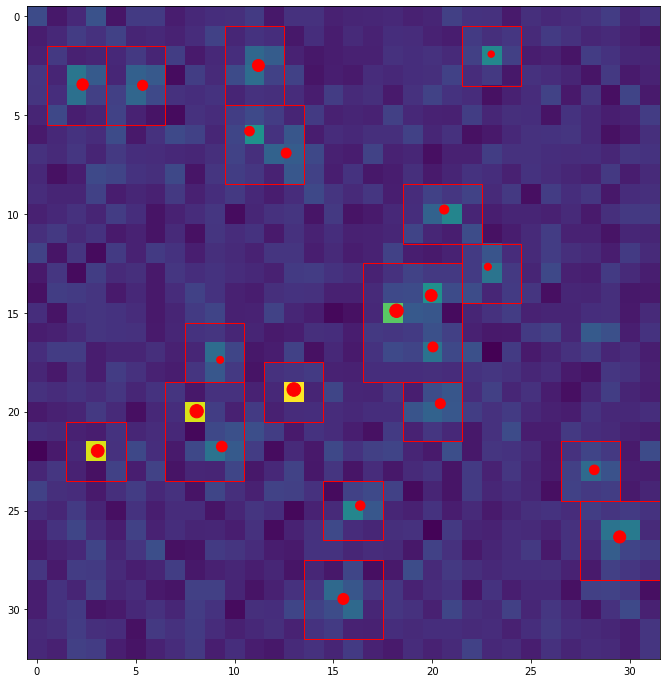

In [157]:
# Plot the boxes
fig, ax = plt.subplots(1)
for b in demo_box_list:
    box_rect = patches.Rectangle((b.y_min - 0.5, b.x_min - 0.5), b.hw()[0], b.hw()[1],
                                                 linewidth = 1, edgecolor = 'r', facecolor = "none")
    ax.add_patch(box_rect)

# Extract the data
demo_x, demo_y, demo_A = np.transpose([[per.x, per.y, per.A] for per in demo_results])

plt.scatter(demo_y, demo_x, color = 'red', marker = 'o', s = 12 * (np.array(demo_A) - 10))
plt.imshow(demo_data)

Now, run the single photon counting algorithm on our image data:

<b>Note: processing of each image would take tens of seconds to minutes, depending on the photon density in it. Processing an array of 20 images will take 1-2 hours. </b>

In [168]:
spc_result = single_photon_counting(image_data)

Finished processing image #20

225832 SPEs found; 64737 MPEs found; total number of photons: 290569

Time elapsed: 8792 seconds

Done and done.

In [170]:
def write_in_csv(spc_result,name='data1.csv'):

    with open(name,'w',newline='') as file:
        writer=csv.writer(file)
        for sper in spc_result:
            x=sper.x
            y=sper.y
            A=sper.A
            if(A>0):
                writer.writerow([x,y,A])
                
write_in_csv(spc_result)

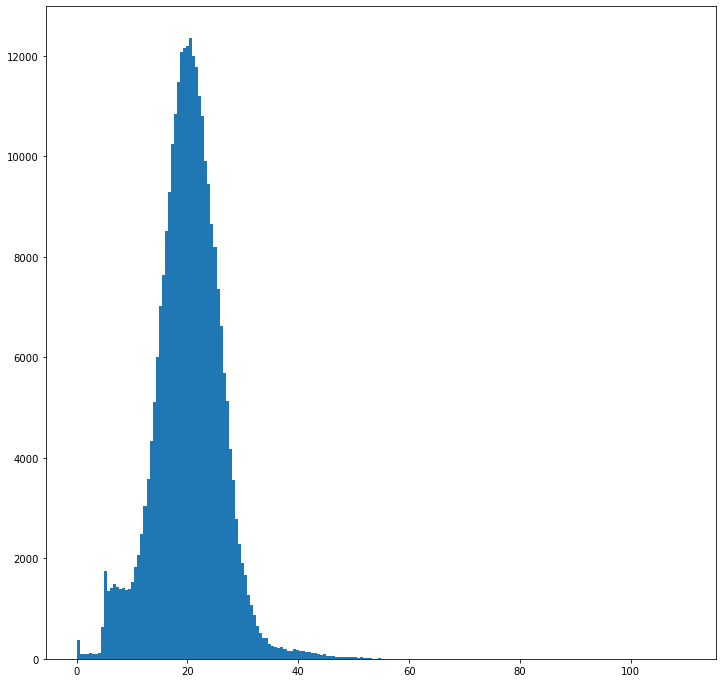

In [172]:
plt.hist([per.A for per in spc_result], bins = 200);

## Bragg Spectroscopy

In [165]:
box_list_7 = boxing(thresholding(image_data[6], thres))

In [166]:

gradient_descent_multi(box_list_7[18159],image_data[6], output = '')

Box data:
[[  7   1   6   3  44]
 [ 18  51  19  13  42]
 [  6  35  21  -8   6]
 [  8   1 -17  -6  14]
 [  9   9  -7 193  20]
 [  3  -7  13  -3   9]]
Photon created at x=1.5, y=1.5
Photon created at x=4.5, y=3.5
2 photon(s) initialised.
----------Initial iteration starts----------
Iteration #1: photon no. 1 has x=1.577286, y=1.508026, sx=0.459984, sy=0.460865, A=18.098357
Iteration #1: photon no. 2 has x=4.504271, y=3.554432, sx=0.248386, sy=0.266047, A=36.412904
Iteration #11: photon no. 1 has x=1.858965, y=1.583918, sx=0.488811, sy=0.530831, A=22.275019
Iteration #11: photon no. 2 has x=4.504235, y=3.565745, sx=0.200000, sy=0.234069, A=35.263170
Convergence reached at iteration #20:
Photon no. 1 has x=1.874979, y=1.607683, sx=0.483229, sy=0.571405, A=23.739418
Distribution matrix of this photon:
[[ 0  3  1  0  0]
 [11 51 20  0  0]
 [ 8 35 13  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
Photon no. 2 has x=4.507991, y=3.646634, sx=0.210179, sy=0.270168, A=31.404038
Dist

[array([1.87497943, 4.50799131]),
 array([1.60768346, 3.64663371]),
 array([23.73941765, 31.40403796]),
 2051.639059546859]